<a href="https://colab.research.google.com/github/Rae-Jiang/DSGA1011_NLP/blob/master/Rui_Q2_1_1%2BQ2_3%2BQ2_4_RESULT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DS-GA 1011 Homework 2
## N-Gram and Neural Language Modeling

In [0]:
import sys

try:
    import jsonlines
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install jsonlines
  
try:
    from tqdm import tqdm
except ImportError:
    print('Installing the package, RESTART THIS CELL')
    !{sys.executable} -m pip install tqdm

In [0]:
import os
import json
import jsonlines
import numpy as np
from tqdm import tqdm
from collections import defaultdict

In [0]:
from google.colab import drive
drive.mount('/content/drive')
basedir = '/content/drive/My Drive/1011 NLP/HW2/Playground_Rui'
# data_folder_path = os.path.join(basedir, 'data')
model_folder_path = os.path.join(basedir, 'model')

Mounted at /content/drive


In [0]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [0]:
datasets, vocab = load_wikitext()

# delta = 0.0005
# for n in [2, 3, 4]:
#     lm = NGramAdditive(n=n, delta=delta, vsize=len(vocab)+1)  # +1 is for <eos>
#     lm.estimate(datasets['train'])

#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Train Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['train'])))
#     print("Baseline (Additive smoothing, n=%d, delta=%.4f)) Valid Perplexity: %.3f" % (n, delta, perplexity(lm, datasets['valid'])))

--2019-10-07 00:21:48--  https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.box.com (nyu.box.com)... 103.116.4.197
Connecting to nyu.box.com (nyu.box.com)|103.116.4.197|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 00:21:48--  https://nyu.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Reusing existing connection to nyu.box.com:443.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json [following]
--2019-10-07 00:21:48--  https://nyu.app.box.com/public/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json
Resolving nyu.app.box.com (nyu.app.box.com)... 103.116.4.199
Connecting to nyu.app.box.com (nyu.app.box.com)|103.116.4.199|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://public.boxcloud.com/d/1/

In [0]:
datasets.keys()

dict_keys(['train', 'valid', 'test'])

In [0]:
print('train size:', len(datasets['train']),'\nvalid size:',len(datasets['valid']),'\ntest size:',len(datasets['test']))

train size: 78274 
valid size: 8464 
test size: 9708


## II. Neural Language Modeling with a Recurrent Neural Network

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, and training code from the lab for use here)

In [0]:
#make dataset
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, RandomSampler, SequentialSampler, DataLoader

class Dictionary(object):
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('<bos>')
        self.add_token('<eos>')
        self.add_token('<pad>')
        self.add_token('<unk>')
        
        for line in tqdm(datasets['train']):  #显示进度条Instantly make your loops show a smart progress meter - just wrap any iterable with tqdm(iterable)
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids['<unk>'] for i in l]
    
    def __len__(self):
        return len(self.tokens)

def tokenize_dataset(datasets, dictionary, ngram_order=2):
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = ['<bos>']*(ngram_order-1) + l + ['<eos>']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))#从第二个词开始就是target，shifted version of sequence as  
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])
    
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('<pad>') # pad_token = 2
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [0]:
wiki_dict = Dictionary(datasets,include_valid=False)
# checking some example
print(' '.join(datasets['train'][3010]))
encoded = wiki_dict.encode_token_seq(datasets['train'][3010])
print(f'\n encoded - {encoded}')
decoded = wiki_dict.decode_idx_seq(encoded)
print(f'\n decoded - {decoded}')

tokenized_datasets = tokenize_dataset(datasets, wiki_dict)
tensor_dataset = {}

for split, listoflists in tokenized_datasets.items():
    tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
tensor_dataset['train'][0]

 18%|█▊        | 14095/78274 [00:00<00:00, 140932.66it/s]

The Nataraja and Ardhanarishvara sculptures are also attributed to the Rashtrakutas .

 encoded - [75, 8816, 30, 8817, 8732, 70, 91, 2960, 13, 6, 8806, 39]

 decoded - ['The', 'Nataraja', 'and', 'Ardhanarishvara', 'sculptures', 'are', 'also', 'attributed', 'to', 'the', 'Rashtrakutas', '.']


100%|██████████| 9708/9708 [00:00<00:00, 137731.67it/s]


(tensor([[ 0,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10,
          19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]]),
 tensor([[ 4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14,  4, 15, 16, 17, 18, 10, 19,
          20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31,  1]]))

In [0]:
loaders = {}

batch_size = 32

for split, wiki_dataset in tensor_dataset.items():
    loaders[split] = DataLoader(wiki_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn)

### II.1 LSTM and Hyper-Parameters

#### make model


In [0]:
# 1.RNN (Baseline)
class RNN_LM(nn.Module):
    """
    This model combines embedding, lstm and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.rnn = nn.RNN(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['dropout'], batch_first=True) #inputs,outputs
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        rnn_output,hidden = self.rnn(embeddings) #return a tuple,out的last slice和hidden一样（因为out give you access to all hidden states in the sequence, hidden will allow you to continue the sequence and backpropagate)        
        logits = self.projection(rnn_output)#why 0?rnn gives all outputs of all hiddens it has computed so far.

        return logits

In [0]:
# 2.LSTM
class LSTM_LM(nn.Module):
    """
    This model combines embedding, lstm and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], dropout=options['dropout'], batch_first=True) #inputs,outputs
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])
        
    def forward(self, encoded_input_sequence):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        lstm_output,hidden = self.lstm(embeddings) #out的last slice和hidden一样（因为out give you access to all hidden states in the sequence, hidden will allow you to continue the sequence and backpropagate)
        logits = self.projection(lstm_output)
        
        return logits

##### RNN

In [0]:
# creating a model, criterion and optimizer
#specify which model(RNN or LSTM) or if use a pretrained or not
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
assert current_device == 'cuda'

load_pretrained = True
model_type = 'rnn'
model_path = os.path.join(model_folder_path,'wiki_rnn_lm.pt')

if load_pretrained:
    if model_type == 'lstm':
        if not os.path.exists('wiki_lstm_lm.pt'):
            raise EOFError('No model downloaded!')
        model_dict = torch.load('wiki_lstm_lm.pt')

        options = model_dict['options']
        model = LSTM_LM(options).to(current_device)
        model.load_state_dict(model_dict['model_dict'])
        
    if model_type =='rnn':
        if not os.path.exists('wiki_rnn_lm.pt'):
            raise EOFError('No model downloaded!')
        model_dict = torch.load(model_path)

        options = model_dict['options']
        model = RNN_LM(options).to(current_device)
        model.load_state_dict(model_dict['model_dict'])

else:
    embedding_dim = 64
    hidden_size = 128
    num_layers = 2
    dropout = 0.1

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_dim,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_dim,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
    }
    if model_type == 'lstm':
        model = LSTM_LM(options).to(current_device)
    if model_type == 'rnn':
        model = RNN_LM(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction='sum')
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [0]:
model

RNN_LM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (rnn): RNN(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)

In [0]:
# now we make same training loop, now with dataset and the model

plot_cache = []

for epoch_number in range(10):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()  # still sum here
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            
            train_non_pad_tokens_cache += non_pad_tokens
            
            loss /= non_pad_tokens  # very important to normalize your current loss before you run .backward()
            
            loss.backward()
            optimizer.step()
                        
            if i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            
    #do valid

    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item()  # still sum here
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            
            valid_non_pad_tokens_cache += non_pad_tokens
            
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
            
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break
if model_type == 'lstm':
    lstm_plot_cache = plot_cache
if model_type == 'rnn':
    rnn_plot_cache = plot_cache

Step 0 avg train loss = 10.4288
Step 100 avg train loss = 7.7435
Step 200 avg train loss = 7.3367
Step 300 avg train loss = 7.1327
Step 400 avg train loss = 7.0006
Step 500 avg train loss = 6.8983
Step 600 avg train loss = 6.8192
Step 700 avg train loss = 6.7519
Step 800 avg train loss = 6.6939
Step 900 avg train loss = 6.6447
Step 1000 avg train loss = 6.6010
Step 1100 avg train loss = 6.5596
Step 1200 avg train loss = 6.5238
Step 1300 avg train loss = 6.4894
Step 1400 avg train loss = 6.4585
Step 1500 avg train loss = 6.4313
Step 1600 avg train loss = 6.4043
Step 1700 avg train loss = 6.3803
Step 1800 avg train loss = 6.3568
Step 1900 avg train loss = 6.3340
Step 2000 avg train loss = 6.3138
Step 2100 avg train loss = 6.2937
Step 2200 avg train loss = 6.2757
Step 2300 avg train loss = 6.2585
Step 2400 avg train loss = 6.2411
Validation loss after 0 epoch = 5.6907
Step 0 avg train loss = 5.5617
Step 100 avg train loss = 5.7252
Step 200 avg train loss = 5.7123
Step 300 avg train loss =

In [0]:
# saving the model, like pickle dump
if not load_pretrained:
    torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict() #all params
    }, model_path) #file name

 ##### LSTM

In [0]:
load_pretrained = False
model_type = 'lstm'
# creating a model, criterion and optimizer
#specify which model(RNN or LSTM) or if use a pretrained or not
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
assert current_device == 'cuda'

if load_pretrained:
    if model_type == 'lstm':
        if not os.path.exists('wiki_lstm_lm.pt'):
            raise EOFError('No model downloaded!')
        model_dict = torch.load('wiki_lstm_lm.pt')

        options = model_dict['options']
        model = LSTM_LM(options).to(current_device)
        model.load_state_dict(model_dict['model_dict'])
        
    if model_type =='rnn':
        if not os.path.exists('wiki_rnn_lm.pt'):
            raise EOFError('No model downloaded!')
        model_dict = torch.load('wiki_rnn_lm.pt')

        options = model_dict['options']
        model = RNN_LM(options).to(current_device)
        model.load_state_dict(model_dict['model_dict'])

else:
    embedding_dim = 64
    hidden_size = 128
    num_layers = 2
    dropout = 0.1

    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_dim,
        'padding_idx': wiki_dict.get_id('<pad>'),
        'input_size': embedding_dim,
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'dropout': dropout,
    }
    if model_type == 'lstm':
        model = LSTM_LM(options).to(current_device)
    if model_type == 'rnn':
        model = RNN_LM(options).to(current_device)

criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id('<pad>'),reduction='sum')
model_parameters = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(model_parameters, lr=0.001)

In [0]:
model

LSTM_LM(
  (lookup): Embedding(33181, 64, padding_idx=2)
  (lstm): LSTM(64, 128, num_layers=2, batch_first=True, dropout=0.1)
  (projection): Linear(in_features=128, out_features=33181, bias=True)
)

In [0]:
# now we make same training loop, now with dataset and the model

plot_cache = []

for epoch_number in range(10):
    avg_loss=0
    if not load_pretrained:
        # do train
        model.train()
        
        train_loss_cache = 0
        train_non_pad_tokens_cache = 0
        
        for i, (inp, target) in enumerate(loaders['train']):
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)
            
            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            train_loss_cache += loss.item()  # still sum here
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            
            train_non_pad_tokens_cache += non_pad_tokens
            
            loss /= non_pad_tokens  # very important to normalize your current loss before you run .backward()
            
            loss.backward()
            optimizer.step()
                        
            if i % 100 == 0:
                avg_loss = train_loss_cache / train_non_pad_tokens_cache
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
            
    #do valid

    valid_loss_cache = 0
    valid_non_pad_tokens_cache = 0
    
    model.eval()
    with torch.no_grad():
        for i, (inp, target) in enumerate(loaders['valid']):
            inp = inp.to(current_device)
            target = target.to(current_device)
            logits = model(inp)

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            valid_loss_cache += loss.item()  # still sum here
            
            ### HERE WE COMPUTE NUMBER OF NON_PAD TOKENS IN THE TARGET
            non_pad_tokens = target.view(-1).ne(wiki_dict.get_id('<pad>')).sum().item()
            
            valid_non_pad_tokens_cache += non_pad_tokens
            
        avg_val_loss = valid_loss_cache / valid_non_pad_tokens_cache
            
        print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))
        
    plot_cache.append((avg_loss, avg_val_loss))

    if load_pretrained:
        break
if model_type == 'lstm':
    lstm_plot_cache = plot_cache
if model_type == 'rnn':
    rnn_plot_cache = plot_cache

Step 0 avg train loss = 10.4010
Step 100 avg train loss = 7.8683
Step 200 avg train loss = 7.5247
Step 300 avg train loss = 7.3656
Step 400 avg train loss = 7.2560
Step 500 avg train loss = 7.1702
Step 600 avg train loss = 7.0986
Step 700 avg train loss = 7.0338
Step 800 avg train loss = 6.9773
Step 900 avg train loss = 6.9283
Step 1000 avg train loss = 6.8843
Step 1100 avg train loss = 6.8434
Step 1200 avg train loss = 6.8054
Step 1300 avg train loss = 6.7713
Step 1400 avg train loss = 6.7398
Step 1500 avg train loss = 6.7079
Step 1600 avg train loss = 6.6802
Step 1700 avg train loss = 6.6537
Step 1800 avg train loss = 6.6285
Step 1900 avg train loss = 6.6045
Step 2000 avg train loss = 6.5809
Step 2100 avg train loss = 6.5583
Step 2200 avg train loss = 6.5378
Step 2300 avg train loss = 6.5175
Step 2400 avg train loss = 6.4974
Validation loss after 0 epoch = 5.8609
Step 0 avg train loss = 6.1006
Step 100 avg train loss = 5.9409
Step 200 avg train loss = 5.9408
Step 300 avg train loss =

In [0]:
# saving the model, like pickle dump
model_path = os.path.join(model_folder_path,'hw2_2.1.1_lstm_lm.pt')
if not load_pretrained:
    torch.save({
        'options': options,
        'loss_cache': plot_cache,
        'model_dict': model.state_dict() #all params
    }, model_path) #file name

#### Results (LSTM vs. Baseline)

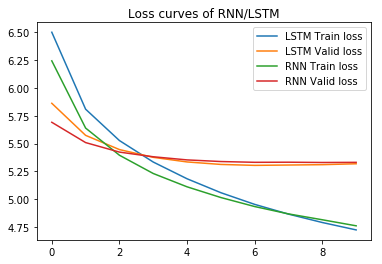

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [i[0] for i in lstm_plot_cache], label='LSTM Train loss')
plt.plot(epochs, [i[1] for i in lstm_plot_cache], label='LSTM Valid loss')
plt.plot(epochs, [i[0] for i in rnn_plot_cache], label='RNN Train loss')
plt.plot(epochs, [i[1] for i in rnn_plot_cache], label='RNN Valid loss')

plt.legend()
plt.title('Loss curves of RNN/LSTM')
plt.show()

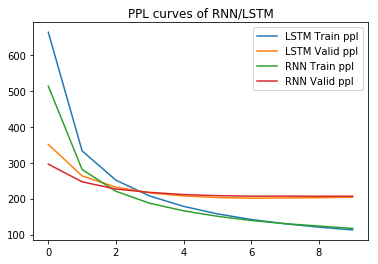

In [0]:
import matplotlib.pyplot as plt
import numpy

epochs = numpy.array(list(range(len(plot_cache))))
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in lstm_plot_cache], label='LSTM Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in lstm_plot_cache], label='LSTM Valid ppl')
plt.plot(epochs, [2**(i[0]/numpy.log(2)) for i in rnn_plot_cache], label='RNN Train ppl')
plt.plot(epochs, [2**(i[1]/numpy.log(2)) for i in rnn_plot_cache], label='RNN Valid ppl')
         
plt.legend()
plt.title('PPL curves of RNN/LSTM')
plt.show()

In [0]:
print('LSTM PPL:',2**(lstm_plot_cache[-1][1]/numpy.log(2)),'RNN PPL',2**(rnn_plot_cache[-1][1]/numpy.log(2)))

LSTM PPL: 204.16428943493878 RNN PPL 206.77883783443752


#### Performance Variation Based on Hyperparameter Values

### II.2 Learned Embeddings

#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [0]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(20,20))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


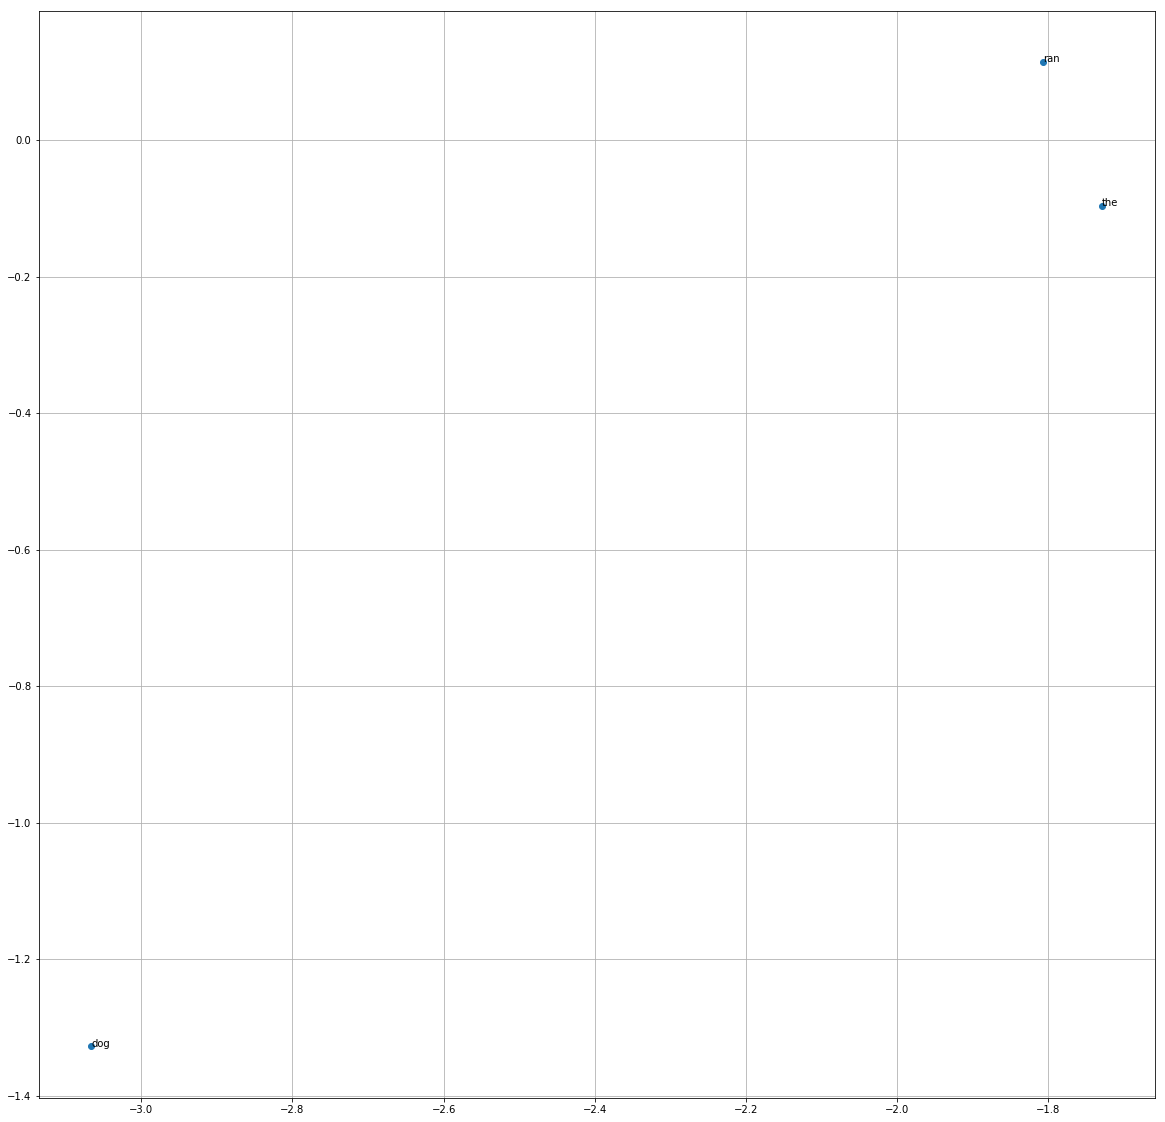

In [0]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### II.2.1 Word Similarity

#### II.2.2 Embedding Layer

#### II.2.3 Projection Layer

### II.3 Scoring

In [0]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
assert current_device == 'cuda'
from google.colab import drive
drive.mount('/content/drive')
basedir = '/content/drive/My Drive/1011 NLP/HW2/Playground_Rui'
# data_folder_path = os.path.join(basedir, 'data')
model_folder_path = os.path.join(basedir, 'model')

#best model
model_dict = torch.load(os.path.join(model_folder_path,'lstm_best_model.pt'))
options = model_dict['options']
options['dropout'] = options.pop('lstm_dropout')
model = LSTM_LM(options).to(current_device)
model.load_state_dict(model_dict['model_dict'])

# #baseline model
# model_dict = torch.load(os.path.join(model_folder_path,'wiki_lstm_lm.pt'))
# options = model_dict['options']
# model = LSTM_LM(options).to(current_device)
# model.load_state_dict(model_dict['model_dict'])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<All keys matched successfully>

In [0]:
options

{'dropout': 0.3,
 'embedding_dim': 512,
 'hidden_size': 1024,
 'input_size': 512,
 'lr': 0.001,
 'num_embeddings': 33178,
 'num_layers': 3,
 'padding_idx': 2}

##### 2.3.1

In [0]:
import numpy as np

def prepare(sentence):
    res_x = []
    res_y = []
    for i, w in enumerate(sentence):
        if i==0:
            continue
        x = sentence[:i]
        y = w
        res_x.append(np.array(x, dtype=np.int_))
        res_y.append(y)
    return np.array(res_x), np.array(res_y)

def cal_loglikelihood(valid_data):
    loglikelihood = 0
    valid_x, valid_y = prepare(valid_data)
    # print(valid_x))
    for i, data_row in enumerate(valid_x):
        # print('data_row:',data_row)
        with torch.no_grad():
            model.eval()
            logits = model(torch.from_numpy(data_row).to('cuda').unsqueeze(0))
            # print(logits.shape)
            correct_y = valid_y[i]
            # print('correct_y:',correct_y)
            probabilities = torch.nn.functional.softmax(logits[0][-1]) #vocab对应的
            # print(probabilities.shape)
            loglikelihood += np.log(probabilities[correct_y].cpu().detach().numpy())
            # print(loglikelihood)
        # if i==0:
        #     break
    return loglikelihood

res = []
for i, valid_data in tqdm(enumerate(tokenized_datasets['valid'])):
    # print(valid_data)
    res.append((datasets['valid'][i],cal_loglikelihood(valid_data)))
    if i % 2000 == 0:
        print(i)  
res = sorted(res,key=lambda x:x[1],reverse=True)

0it [00:00, ?it/s]/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
2it [00:00,  2.46it/s]

0


2002it [08:39,  4.29it/s]

2000


4001it [18:00,  3.78it/s]

4000


6001it [27:22,  4.43it/s]

6000


8001it [36:51,  3.03it/s]

8000


8464it [38:50,  5.35it/s]


In [0]:
print('bos:',wiki_dict.get_id('<bos>'),'eos:',wiki_dict.get_id('<eos>'),'pad:',wiki_dict.get_id('<pad>'))
print('=:',wiki_dict.get_id('='))
print('@-@:', wiki_dict.get_id('@-@'))

bos: 0 eos: 1 pad: 2
=: 1907
@-@: 23


#### II.3.2 Highest and Lowest scoring sequences

In [0]:
for i in res[:10]:
    print(i[1])

-15.417704246938229
-16.557723343372345
-19.037224277853966
-21.969595208764076
-24.21350160613656
-24.42048878967762
-24.813802510499954
-25.596893843263388
-26.17766149714589
-26.198488762776833


In [0]:
print('10 Highest scoring sequences:')
for i in res[:10]:
    print(' '.join(i[0]))
print('--'*30)
print('10 Lowest scoring sequences=:')
for i in res[-10:-1]:
    print(' '.join(i[0]))

10 Highest scoring sequences:
= = Post @-@ war career = =
= = Early life and education = =
= = Post @-@ war period = =
= = = Scientology sources = = =
= = = Hit list = = =
= = Culture and the arts = =
= = Return to New Zealand = =
= = = <unk> from the stage = = =
= = = Army returns = = =
It originally aired on NBC on April 14 , 2011 .
------------------------------------------------------------
10 Lowest scoring sequences=:
On December 7 , 2007 , German federal and state interior ministers expressed the opinion that the Scientology organization was continuing to pursue anti @-@ constitutional goals , <unk> " essential basic and human rights like the dignity of man or the right to equal treatment " , and asked Germany 's domestic intelligence agencies to collect and evaluate the information required for a possible judicial inquiry aimed at banning the organization .
Officials of the strictly amateur Rugby Football Union ( RFU ) had become increasingly concerned at the behaviour of the N

#### II.3.3 Modified sequences

In [0]:
print(res[9][0])

['It', 'originally', 'aired', 'on', 'NBC', 'on', 'April', '14', ',', '2011', '.']


In [0]:
sample = ['<bos>','It', 'originally', 'aired', 'on', 'NBC', 'on', 'April', '14', ',', '2011', '.','<eos>']

higher_seq = ['<bos>','It', 'originally', 'aired', 'on', 'NBC','on', 'April', '19', ',', '2011', '.','<eos>']

lower_seq = ['<bos>','It', 'originally', 'aired', 'on', 'BBC','on', 'April', '19', ',', '2011', '.','<eos>']
print(f'original seq: {(sample)}, \nlog likelihood: {cal_loglikelihood(wiki_dict.encode_token_seq(sample))}')
print(f'\nmodified seq: {higher_seq}, \nlog likelihood: {cal_loglikelihood(wiki_dict.encode_token_seq(higher_seq))}')
print(f'\nmodified seq: {lower_seq}, \nlog likelihood: {cal_loglikelihood(wiki_dict.encode_token_seq(lower_seq))}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:27: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


original seq: ['<bos>', 'It', 'originally', 'aired', 'on', 'NBC', 'on', 'April', '14', ',', '2011', '.', '<eos>'], 
log likelihood: -26.198488762776833

modified seq: ['<bos>', 'It', 'originally', 'aired', 'on', 'NBC', 'on', 'April', '19', ',', '2011', '.', '<eos>'], 
log likelihood: -26.069971794029698

modified seq: ['<bos>', 'It', 'originally', 'aired', 'on', 'BBC', 'on', 'April', '19', ',', '2011', '.', '<eos>'], 
log likelihood: -30.446250190376304


### II.4 Sampling

In [0]:
def get_sample():
    seq = np.array([0]) #only have <bos>
    while seq[-1]!= 1: # <eos>:1
        with torch.no_grad():
            model.eval()
            logits = model(torch.from_numpy(seq).to('cuda').unsqueeze(0))
            probabilities = torch.nn.functional.softmax(logits[0][-1])
            a = torch.multinomial(probabilities, 1, out=None).cpu()
            seq = np.append(seq, a)
    return seq

samples_1000 = []
for i in range(1000):
    samp = sample()
    # print(f'the {i}th sample sequence: {wiki_dict.decode_idx_seq(list(samp))}')
    samples_1000.append(samp)
    if i % 100 ==0:
        print(i)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  import sys


0
100
200
300
400
500
600
700
800
900


#### II.4.3 Number of unique tokens and sequence length 

(1,000 samples vs. 1,000 randomly selected validation-set sequences)

In [0]:
from random import sample 
valid_1000 = sample(tokenized_datasets['valid'],1000)

In [0]:
def get_info(samples):
    l = [item for sublist in samples for item in sublist]
    uniques = set(l)
    return len(uniques),len(l)
num_unique,seq_len = get_info(samples_1000)
print('In 1000 samples we generated from best LSTM:')
print('number of unique tokens:',num_unique,'sequence length:',seq_len)
print('---'*20)
print('In 1000 randomly selected validation-set sequences:')
num_unique,seq_len = get_info(valid_1000)
print('number of unique tokens:',num_unique,'sequence length:',seq_len)

In 1000 samples we generated from best LSTM:
number of unique tokens: 6043 sequence length: 25269
------------------------------------------------------------
In 1000 randomly selected validation-set sequences:
number of unique tokens: 5094 sequence length: 25408


#### II.4.4 Example Samples

In [0]:
for i in samples_1000[:3]:
    print(' '.join(wiki_dict.decode_idx_seq(list(i))))

<bos> It was only ranked in the centre of regulatory artist Nancy Robert Park , whom approached one person which eclipsed it . <eos>
<bos> The more stage quickly considered about the victory of the start was not visited , as he been Eve for the starting and subsequently receives authenticity to excommunication relationships . <eos>
<bos> The Twins increased to Ashley Faulkner , understanding a motion line on the 2002 network program . <eos>


- I can tell that these 3 sequences are model-generated rather than human-generated.
- I don't think these samples stay on topic.
- I think most of them are grammatically correct.